In [ ]:
!pip install konlpy

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 59 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 39 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datasets import load_from_disk
from transformers import AutoTokenizer
import re
from difflib import SequenceMatcher
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# train_dataset을 불러오고 싶은 경우
from datasets import load_from_disk
dataset = load_from_disk("/content/drive/MyDrive/data/data/train_dataset")

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'context', 'question', 'id', 'answers', 'document_id', '__index_level_0__'],
        num_rows: 3952
    })
    validation: Dataset({
        features: ['title', 'context', 'question', 'id', 'answers', 'document_id', '__index_level_0__'],
        num_rows: 240
    })
})

In [ ]:
class MRCDataEDA:
    def __init__(self, dataset_path, tokenizer_name='klue/bert-base'):
        """MRC 데이터 로드 및 초기화"""
        # HuggingFace datasets 형식으로 로드
        self.dataset = load_from_disk(dataset_path)
        self.train_data = self.dataset['train']

        # Tokenizer 로드
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

        # DataFrame으로 변환
        self.df = pd.DataFrame({
            'id': self.train_data['id'],
            'title': self.train_data['title'],
            'context': self.train_data['context'],
            'question': self.train_data['question'],
            'answers': self.train_data['answers'],
            'document_id': self.train_data['document_id']
        })

        print(f"✅ 데이터 로드 완료: {len(self.df)} 개의 샘플")
        print(f"✅ Dataset keys: {self.dataset.keys()}")
        print(f"✅ Train 데이터 특성: {self.train_data.features}")
        print(f"✅ Tokenizer 로드 완료: {tokenizer_name}")

    def basic_info(self):
        """기본 정보 출력"""
        print("\n" + "="*80)
        print("📊 기본 데이터 정보")
        print("="*80)
        print(f"전체 샘플 수: {len(self.df)}")
        print(f"컬럼: {list(self.df.columns)}")
        print(f"\n결측치:\n{self.df.isnull().sum()}")
        print(f"\n데이터 타입:\n{self.df.dtypes}")

        # 샘플 데이터 출력
        print("\n[샘플 데이터 예시]")
        sample = self.train_data[0]
        print(f"ID: {sample['id']}")
        print(f"Title: {sample['title']}")
        print(f"Question: {sample['question']}")
        print(f"Context (처음 200자): {sample['context'][:200]}...")
        print(f"Answers: {sample['answers']}")
        print(f"Document ID: {sample['document_id']}")

    def analyze_text_length(self):
        """텍스트 길이 분석"""
        print("\n" + "="*80)
        print("📏 텍스트 길이 분석")
        print("="*80)

        # Context 길이 분석
        context_lengths = self.df['context'].apply(lambda x: len(x))

        # Question 길이 분석
        question_lengths = self.df['question'].apply(lambda x: len(x))

        # Answer 길이 분석
        answer_lengths = []
        for answers in self.df['answers']:
            if answers['text']:
                answer_lengths.append(len(answers['text'][0]))
            else:
                answer_lengths.append(0)

        # 통계 출력
        print("\n[Context 통계]")
        print(f"평균: {context_lengths.mean():.2f} 글자")
        print(f"중앙값: {context_lengths.median():.2f} 글자")
        print(f"최소: {context_lengths.min()} 글자")
        print(f"최대: {context_lengths.max()} 글자")
        print(f"표준편차: {context_lengths.std():.2f}")

        print("\n[Question 통계]")
        print(f"평균: {question_lengths.mean():.2f} 글자")
        print(f"중앙값: {question_lengths.median():.2f} 글자")
        print(f"최소: {question_lengths.min()} 글자")
        print(f"최대: {question_lengths.max()} 글자")

        print("\n[Answer 통계]")
        answer_lengths = np.array(answer_lengths)
        print(f"평균: {answer_lengths.mean():.2f} 글자")
        print(f"중앙값: {np.median(answer_lengths):.2f} 글자")
        print(f"최소: {answer_lengths.min()} 글자")
        print(f"최대: {answer_lengths.max()} 글자")

        # 시각화
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        axes[0].hist(context_lengths, bins=50, edgecolor='black', alpha=0.7)
        axes[0].set_title('Context 길이 분포', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('길이 (글자 수)')
        axes[0].set_ylabel('빈도')
        axes[0].axvline(context_lengths.mean(), color='red', linestyle='--', label=f'평균: {context_lengths.mean():.0f}')
        axes[0].legend()

        axes[1].hist(question_lengths, bins=30, edgecolor='black', alpha=0.7, color='orange')
        axes[1].set_title('Question 길이 분포', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('길이 (글자 수)')
        axes[1].set_ylabel('빈도')
        axes[1].axvline(question_lengths.mean(), color='red', linestyle='--', label=f'평균: {question_lengths.mean():.0f}')
        axes[1].legend()

        axes[2].hist(answer_lengths, bins=30, edgecolor='black', alpha=0.7, color='green')
        axes[2].set_title('Answer 길이 분포', fontsize=14, fontweight='bold')
        axes[2].set_xlabel('길이 (글자 수)')
        axes[2].set_ylabel('빈도')
        axes[2].axvline(answer_lengths.mean(), color='red', linestyle='--', label=f'평균: {answer_lengths.mean():.0f}')
        axes[2].legend()

        plt.tight_layout()
        plt.savefig('text_length_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()

        return context_lengths, question_lengths, answer_lengths

    def analyze_answer_position(self):
        """답변 위치 분석"""
        print("\n" + "="*80)
        print("📍 답변 위치 분석")
        print("="*80)

        answer_positions = []
        relative_positions = []

        for idx, row in self.df.iterrows():
            if row['answers']['answer_start']:
                start_pos = row['answers']['answer_start'][0]
                context_len = len(row['context'])

                answer_positions.append(start_pos)
                relative_positions.append(start_pos / context_len * 100)

        answer_positions = np.array(answer_positions)
        relative_positions = np.array(relative_positions)

        print(f"\n[절대 위치 통계]")
        print(f"평균: {answer_positions.mean():.2f}")
        print(f"중앙값: {np.median(answer_positions):.2f}")
        print(f"최소: {answer_positions.min()}")
        print(f"최대: {answer_positions.max()}")

        print(f"\n[상대 위치 통계 (백분율)]")
        print(f"평균: {relative_positions.mean():.2f}%")
        print(f"중앙값: {np.median(relative_positions):.2f}%")

        # Context를 3등분하여 답변 분포 확인
        first_third = sum(relative_positions < 33.3)
        second_third = sum((relative_positions >= 33.3) & (relative_positions < 66.6))
        third_third = sum(relative_positions >= 66.6)

        print(f"\n[Context 구간별 답변 분포]")
        print(f"앞부분 (0-33%): {first_third}개 ({first_third/len(relative_positions)*100:.2f}%)")
        print(f"중간부분 (33-66%): {second_third}개 ({second_third/len(relative_positions)*100:.2f}%)")
        print(f"뒷부분 (66-100%): {third_third}개 ({third_third/len(relative_positions)*100:.2f}%)")

        # 시각화
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        axes[0].hist(answer_positions, bins=50, edgecolor='black', alpha=0.7, color='purple')
        axes[0].set_title('답변 절대 위치 분포', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('위치 (글자 인덱스)')
        axes[0].set_ylabel('빈도')

        axes[1].hist(relative_positions, bins=50, edgecolor='black', alpha=0.7, color='teal')
        axes[1].set_title('답변 상대 위치 분포 (%)', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('상대 위치 (%)')
        axes[1].set_ylabel('빈도')
        axes[1].axvline(33.3, color='red', linestyle='--', alpha=0.5)
        axes[1].axvline(66.6, color='red', linestyle='--', alpha=0.5)

        plt.tight_layout()
        plt.savefig('answer_position_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()

    def analyze_document_ids(self):
        """Document ID 분석"""
        print("\n" + "="*80)
        print("📄 Document ID 분석")
        print("="*80)

        doc_id_counts = Counter(self.df['document_id'])

        print(f"고유 Document 수: {len(doc_id_counts)}")
        print(f"평균 Document당 Question 수: {np.mean(list(doc_id_counts.values())):.2f}")
        print(f"최대 Question 수를 가진 Document: {max(doc_id_counts.values())}개")
        print(f"최소 Question 수를 가진 Document: {min(doc_id_counts.values())}개")

        print(f"\n[상위 10개 Document]")
        for doc_id, count in doc_id_counts.most_common(10):
            print(f"Document {doc_id}: {count}개의 질문")

        # 시각화
        plt.figure(figsize=(12, 6))
        counts = sorted(doc_id_counts.values(), reverse=True)
        plt.bar(range(len(counts)), counts, alpha=0.7, color='steelblue')
        plt.title('Document별 Question 수 분포', fontsize=14, fontweight='bold')
        plt.xlabel('Document (정렬됨)')
        plt.ylabel('Question 수')
        plt.tight_layout()
        plt.savefig('document_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()

    def analyze_question_types(self):
        """질문 유형 분석"""
        print("\n" + "="*80)
        print("❓ 질문 유형 분석")
        print("="*80)

        # 질문 시작 단어 분석
        question_starters = []
        for q in self.df['question']:
            first_word = q.split()[0] if q.split() else ''
            question_starters.append(first_word)

        starter_counts = Counter(question_starters)

        print(f"\n[질문 시작 단어 TOP 20]")
        for word, count in starter_counts.most_common(20):
            print(f"{word}: {count}개 ({count/len(self.df)*100:.2f}%)")

        # 의문사 분석
        question_words = ['누가', '누구', '무엇', '무슨', '언제', '어디', '어느', '왜', '어떻게', '몇']
        question_word_counts = {word: 0 for word in question_words}

        for q in self.df['question']:
            for word in question_words:
                if word in q:
                    question_word_counts[word] += 1

        print(f"\n[의문사 포함 빈도]")
        for word, count in sorted(question_word_counts.items(), key=lambda x: x[1], reverse=True):
            print(f"{word}: {count}개 ({count/len(self.df)*100:.2f}%)")

        # 시각화
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        top_starters = dict(starter_counts.most_common(15))
        axes[0].barh(list(top_starters.keys()), list(top_starters.values()), color='coral')
        axes[0].set_title('질문 시작 단어 TOP 15', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('빈도')
        axes[0].invert_yaxis()

        axes[1].barh(list(question_word_counts.keys()), list(question_word_counts.values()), color='lightgreen')
        axes[1].set_title('의문사 포함 빈도', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('빈도')
        axes[1].invert_yaxis()

        plt.tight_layout()
        plt.savefig('question_type_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

    def analyze_title_distribution(self):
        """제목 분포 분석"""
        print("\n" + "="*80)
        print("📚 제목 분포 분석")
        print("="*80)

        title_counts = Counter(self.df['title'])

        print(f"고유 제목 수: {len(title_counts)}")
        print(f"\n[상위 20개 제목]")
        for title, count in title_counts.most_common(20):
            print(f"{title}: {count}개")

    def analyze_token_length(self):
        """토큰 길이 분석 (BERT Tokenizer 기준)"""
        print("\n" + "="*80)
        print("🔤 토큰 길이 분석 (BERT Tokenizer)")
        print("="*80)

        context_token_lengths = []
        question_token_lengths = []
        combined_token_lengths = []

        print("토큰화 진행 중...")
        for idx, row in self.df.iterrows():
            if idx % 1000 == 0:
                print(f"  진행률: {idx}/{len(self.df)}")

            # Context 토큰 길이
            context_tokens = self.tokenizer.encode(row['context'], add_special_tokens=False)
            context_token_lengths.append(len(context_tokens))

            # Question 토큰 길이
            question_tokens = self.tokenizer.encode(row['question'], add_special_tokens=False)
            question_token_lengths.append(len(question_tokens))

            # Combined (Question + Context) 토큰 길이
            combined_tokens = self.tokenizer.encode(
                row['question'],
                row['context'],
                add_special_tokens=True,
                truncation=False
            )
            combined_token_lengths.append(len(combined_tokens))

        context_token_lengths = np.array(context_token_lengths)
        question_token_lengths = np.array(question_token_lengths)
        combined_token_lengths = np.array(combined_token_lengths)

        print("\n[Context 토큰 통계]")
        print(f"평균: {context_token_lengths.mean():.2f} 토큰")
        print(f"중앙값: {np.median(context_token_lengths):.2f} 토큰")
        print(f"최소: {context_token_lengths.min()} 토큰")
        print(f"최대: {context_token_lengths.max()} 토큰")

        print("\n[Question 토큰 통계]")
        print(f"평균: {question_token_lengths.mean():.2f} 토큰")
        print(f"중앙값: {np.median(question_token_lengths):.2f} 토큰")
        print(f"최소: {question_token_lengths.min()} 토큰")
        print(f"최대: {question_token_lengths.max()} 토큰")

        print("\n[Combined (Q+C) 토큰 통계]")
        print(f"평균: {combined_token_lengths.mean():.2f} 토큰")
        print(f"중앙값: {np.median(combined_token_lengths):.2f} 토큰")
        print(f"최소: {combined_token_lengths.min()} 토큰")
        print(f"최대: {combined_token_lengths.max()} 토큰")

        # 512 토큰 초과 샘플 분석
        over_512 = sum(combined_token_lengths > 512)
        print(f"\n[512 토큰 초과 샘플]")
        print(f"개수: {over_512}개 ({over_512/len(self.df)*100:.2f}%)")

        # 시각화
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        axes[0, 0].hist(context_token_lengths, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
        axes[0, 0].set_title('Context 토큰 길이 분포', fontsize=14, fontweight='bold')
        axes[0, 0].set_xlabel('토큰 수')
        axes[0, 0].set_ylabel('빈도')
        axes[0, 0].axvline(context_token_lengths.mean(), color='red', linestyle='--',
                          label=f'평균: {context_token_lengths.mean():.0f}')
        axes[0, 0].legend()

        axes[0, 1].hist(question_token_lengths, bins=30, edgecolor='black', alpha=0.7, color='orange')
        axes[0, 1].set_title('Question 토큰 길이 분포', fontsize=14, fontweight='bold')
        axes[0, 1].set_xlabel('토큰 수')
        axes[0, 1].set_ylabel('빈도')
        axes[0, 1].axvline(question_token_lengths.mean(), color='red', linestyle='--',
                          label=f'평균: {question_token_lengths.mean():.0f}')
        axes[0, 1].legend()

        axes[1, 0].hist(combined_token_lengths, bins=50, edgecolor='black', alpha=0.7, color='green')
        axes[1, 0].set_title('Combined (Q+C) 토큰 길이 분포', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('토큰 수')
        axes[1, 0].set_ylabel('빈도')
        axes[1, 0].axvline(512, color='red', linestyle='--', linewidth=2, label='512 토큰 제한')
        axes[1, 0].axvline(combined_token_lengths.mean(), color='blue', linestyle='--',
                          label=f'평균: {combined_token_lengths.mean():.0f}')
        axes[1, 0].legend()

        # 박스플롯
        axes[1, 1].boxplot([context_token_lengths, question_token_lengths, combined_token_lengths],
                          labels=['Context', 'Question', 'Combined'])
        axes[1, 1].set_title('토큰 길이 박스플롯', fontsize=14, fontweight='bold')
        axes[1, 1].set_ylabel('토큰 수')
        axes[1, 1].axhline(512, color='red', linestyle='--', linewidth=2, label='512 토큰 제한')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('token_length_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

    def analyze_unanswerable_questions(self):
        """답변 불가능한 질문 분석"""
        print("\n" + "="*80)
        print("❌ 답변 불가능 질문 분석")
        print("="*80)

        unanswerable_count = 0
        answerable_count = 0

        for answers in self.df['answers']:
            if not answers['text'] or len(answers['text']) == 0 or answers['text'][0] == '':
                unanswerable_count += 1
            else:
                answerable_count += 1

        total = len(self.df)
        print(f"전체 질문 수: {total}")
        print(f"답변 가능 질문: {answerable_count}개 ({answerable_count/total*100:.2f}%)")
        print(f"답변 불가능 질문: {unanswerable_count}개 ({unanswerable_count/total*100:.2f}%)")

        # 시각화
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        labels = ['답변 가능', '답변 불가능']
        sizes = [answerable_count, unanswerable_count]
        colors = ['#66b3ff', '#ff9999']
        explode = (0.05, 0.05)

        ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
               shadow=True, startangle=90, textprops={'fontsize': 12})
        ax.set_title('답변 가능 vs 불가능 질문 비율', fontsize=14, fontweight='bold')

        plt.tight_layout()
        plt.savefig('unanswerable_questions.png', dpi=300, bbox_inches='tight')
        plt.show()

    def analyze_context_question_similarity(self):
        """Context-Question 유사도 분석"""
        print("\n" + "="*80)
        print("🔗 Context-Question 유사도 분석")
        print("="*80)

        word_overlap_ratios = []
        char_overlap_ratios = []

        for idx, row in self.df.iterrows():
            if idx % 1000 == 0:
                print(f"  진행률: {idx}/{len(self.df)}")

            context = row['context']
            question = row['question']

            # 단어 단위 중복도
            context_words = set(context.split())
            question_words = set(question.split())

            if len(question_words) > 0:
                word_overlap = len(context_words & question_words) / len(question_words)
                word_overlap_ratios.append(word_overlap)

            # 문자 단위 유사도
            char_similarity = SequenceMatcher(None, context, question).ratio()
            char_overlap_ratios.append(char_similarity)

        word_overlap_ratios = np.array(word_overlap_ratios)
        char_overlap_ratios = np.array(char_overlap_ratios)

        print(f"\n[단어 중복도 통계]")
        print(f"평균: {word_overlap_ratios.mean():.4f}")
        print(f"중앙값: {np.median(word_overlap_ratios):.4f}")
        print(f"최소: {word_overlap_ratios.min():.4f}")
        print(f"최대: {word_overlap_ratios.max():.4f}")

        print(f"\n[문자 유사도 통계]")
        print(f"평균: {char_overlap_ratios.mean():.4f}")
        print(f"중앙값: {np.median(char_overlap_ratios):.4f}")
        print(f"최소: {char_overlap_ratios.min():.4f}")
        print(f"최대: {char_overlap_ratios.max():.4f}")

        # 시각화
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        axes[0].hist(word_overlap_ratios, bins=50, edgecolor='black', alpha=0.7, color='purple')
        axes[0].set_title('Question 단어의 Context 중복도', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('중복 비율')
        axes[0].set_ylabel('빈도')
        axes[0].axvline(word_overlap_ratios.mean(), color='red', linestyle='--',
                       label=f'평균: {word_overlap_ratios.mean():.2f}')
        axes[0].legend()

        axes[1].hist(char_overlap_ratios, bins=50, edgecolor='black', alpha=0.7, color='teal')
        axes[1].set_title('Context-Question 문자 유사도', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('유사도')
        axes[1].set_ylabel('빈도')
        axes[1].axvline(char_overlap_ratios.mean(), color='red', linestyle='--',
                       label=f'평균: {char_overlap_ratios.mean():.2f}')
        axes[1].legend()

        plt.tight_layout()
        plt.savefig('context_question_similarity.png', dpi=300, bbox_inches='tight')
        plt.show()

    def analyze_answer_type(self):
        """답변 타입 분석"""
        print("\n" + "="*80)
        print("🏷️  답변 타입 분석")
        print("="*80)

        answer_types = {
            '숫자': 0,
            '날짜/시간': 0,
            '인명': 0,
            '지명': 0,
            '기관/조직': 0,
            '일반 명사구': 0
        }

        # 정규표현식 패턴
        number_pattern = re.compile(r'\d+')
        date_pattern = re.compile(r'\d{4}년|\d{1,2}월|\d{1,2}일|년|월|일')

        for answers in self.df['answers']:
            if answers['text'] and len(answers['text']) > 0:
                answer = answers['text'][0]

                # 숫자
                if number_pattern.search(answer) and len(answer) < 20:
                    answer_types['숫자'] += 1
                # 날짜/시간
                elif date_pattern.search(answer):
                    answer_types['날짜/시간'] += 1
                # 조사로 간단한 휴리스틱 분류
                elif any(word in answer for word in ['대통령', '장관', '의원', '총리', '왕']):
                    answer_types['인명'] += 1
                elif any(word in answer for word in ['시', '도', '구', '군', '국']):
                    answer_types['지명'] += 1
                elif any(word in answer for word in ['회사', '기업', '대학', '학교', '정부', '위원회']):
                    answer_types['기관/조직'] += 1
                else:
                    answer_types['일반 명사구'] += 1

        print("\n[답변 타입 분포]")
        for answer_type, count in sorted(answer_types.items(), key=lambda x: x[1], reverse=True):
            print(f"{answer_type}: {count}개 ({count/len(self.df)*100:.2f}%)")

        # 시각화
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))

        types = list(answer_types.keys())
        counts = list(answer_types.values())
        colors = plt.cm.Set3(range(len(types)))

        bars = ax.barh(types, counts, color=colors, edgecolor='black', alpha=0.8)
        ax.set_title('답변 타입 분포', fontsize=14, fontweight='bold')
        ax.set_xlabel('개수')
        ax.invert_yaxis()

        # 막대 위에 값 표시
        for bar, count in zip(bars, counts):
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2,
                   f' {count} ({count/len(self.df)*100:.1f}%)',
                   ha='left', va='center')

        plt.tight_layout()
        plt.savefig('answer_type_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()

    def analyze_sentence_level_answer(self):
        """문장 단위 답변 위치 분석"""
        print("\n" + "="*80)
        print("📝 문장 단위 답변 위치 분석")
        print("="*80)

        sentence_positions = []
        total_sentences_list = []

        for idx, row in self.df.iterrows():
            if idx % 1000 == 0:
                print(f"  진행률: {idx}/{len(self.df)}")

            context = row['context']
            answers = row['answers']

            if not answers['answer_start'] or len(answers['answer_start']) == 0:
                continue

            answer_start = answers['answer_start'][0]

            # 문장 분리 (간단한 방법)
            sentences = re.split(r'[.!?]\s+', context)

            # 답변이 몇 번째 문장에 있는지 찾기
            char_count = 0
            answer_sentence_idx = -1

            for sent_idx, sentence in enumerate(sentences):
                char_count += len(sentence) + 2  # 구두점과 공백 고려
                if char_count > answer_start:
                    answer_sentence_idx = sent_idx
                    break

            if answer_sentence_idx != -1:
                sentence_positions.append(answer_sentence_idx + 1)  # 1부터 시작
                total_sentences_list.append(len(sentences))

        sentence_positions = np.array(sentence_positions)
        total_sentences_list = np.array(total_sentences_list)

        print(f"\n[문장 위치 통계]")
        print(f"평균 답변 위치: {sentence_positions.mean():.2f}번째 문장")
        print(f"중앙값: {np.median(sentence_positions):.2f}번째 문장")
        print(f"최소: {sentence_positions.min()}번째 문장")
        print(f"최대: {sentence_positions.max()}번째 문장")

        print(f"\n[Context 문장 수 통계]")
        print(f"평균: {total_sentences_list.mean():.2f}개")
        print(f"중앙값: {np.median(total_sentences_list):.2f}개")
        print(f"최소: {total_sentences_list.min()}개")
        print(f"최대: {total_sentences_list.max()}개")

        # 첫 3개 문장에 답변이 있는 비율
        first_three = sum(sentence_positions <= 3)
        print(f"\n처음 3개 문장 내 답변: {first_three}개 ({first_three/len(sentence_positions)*100:.2f}%)")

        # 시각화
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        axes[0].hist(sentence_positions, bins=min(50, sentence_positions.max()),
                    edgecolor='black', alpha=0.7, color='coral')
        axes[0].set_title('답변이 위치한 문장 번호 분포', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('문장 번호')
        axes[0].set_ylabel('빈도')
        axes[0].axvline(sentence_positions.mean(), color='red', linestyle='--',
                       label=f'평균: {sentence_positions.mean():.1f}')
        axes[0].legend()

        axes[1].hist(total_sentences_list, bins=min(50, total_sentences_list.max()),
                    edgecolor='black', alpha=0.7, color='lightgreen')
        axes[1].set_title('Context 내 전체 문장 수 분포', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('문장 수')
        axes[1].set_ylabel('빈도')
        axes[1].axvline(total_sentences_list.mean(), color='red', linestyle='--',
                       label=f'평균: {total_sentences_list.mean():.1f}')
        axes[1].legend()

        plt.tight_layout()
        plt.savefig('sentence_level_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

    def analyze_duplicate_questions(self):
        """중복 및 유사 질문 분석"""
        print("\n" + "="*80)
        print("🔄 중복 및 유사 질문 분석")
        print("="*80)

        # Document별 질문 그룹화
        doc_questions = {}
        for idx, row in self.df.iterrows():
            doc_id = row['document_id']
            if doc_id not in doc_questions:
                doc_questions[doc_id] = []
            doc_questions[doc_id].append(row['question'])

        # 완전 중복 질문 찾기
        all_questions = self.df['question'].tolist()
        question_counts = Counter(all_questions)
        duplicate_questions = {q: c for q, c in question_counts.items() if c > 1}

        print(f"\n[중복 질문 통계]")
        print(f"전체 고유 질문 수: {len(question_counts)}")
        print(f"중복되는 질문 수: {len(duplicate_questions)}")
        print(f"중복 질문으로 인한 총 샘플 수: {sum(duplicate_questions.values())}")

        if len(duplicate_questions) > 0:
            print(f"\n[가장 많이 중복된 질문 TOP 10]")
            for question, count in sorted(duplicate_questions.items(), key=lambda x: x[1], reverse=True)[:10]:
                print(f"  ({count}회) {question}")

        # Document별 질문 다양성
        doc_diversity = []
        for doc_id, questions in doc_questions.items():
            if len(questions) > 1:
                unique_ratio = len(set(questions)) / len(questions)
                doc_diversity.append(unique_ratio)

        if len(doc_diversity) > 0:
            doc_diversity = np.array(doc_diversity)
            print(f"\n[Document별 질문 다양성]")
            print(f"평균 고유 질문 비율: {doc_diversity.mean():.4f}")
            print(f"중앙값: {np.median(doc_diversity):.4f}")

        # 질문 길이 유사도 (같은 document 내)
        similar_length_pairs = 0
        total_pairs = 0

        for doc_id, questions in doc_questions.items():
            if len(questions) > 1:
                for i in range(len(questions)):
                    for j in range(i+1, len(questions)):
                        total_pairs += 1
                        len_diff = abs(len(questions[i]) - len(questions[j]))
                        if len_diff < 5:  # 길이 차이가 5글자 이하
                            similar_length_pairs += 1

        if total_pairs > 0:
            print(f"\n[같은 Document 내 질문 쌍 분석]")
            print(f"전체 질문 쌍: {total_pairs}")
            print(f"유사한 길이의 질문 쌍: {similar_length_pairs} ({similar_length_pairs/total_pairs*100:.2f}%)")

        # 시각화
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # 중복 횟수 분포
        if len(duplicate_questions) > 0:
            dup_counts = list(duplicate_questions.values())
            axes[0].hist(dup_counts, bins=range(2, max(dup_counts)+2),
                        edgecolor='black', alpha=0.7, color='salmon')
            axes[0].set_title('질문 중복 횟수 분포', fontsize=14, fontweight='bold')
            axes[0].set_xlabel('중복 횟수')
            axes[0].set_ylabel('질문 수')
            axes[0].set_xticks(range(2, max(dup_counts)+1))
        else:
            axes[0].text(0.5, 0.5, '중복 질문 없음', ha='center', va='center', fontsize=14)
            axes[0].set_xlim(0, 1)
            axes[0].set_ylim(0, 1)

        # Document별 질문 다양성
        if len(doc_diversity) > 0:
            axes[1].hist(doc_diversity, bins=20, edgecolor='black', alpha=0.7, color='lightblue')
            axes[1].set_title('Document별 질문 고유성 비율', fontsize=14, fontweight='bold')
            axes[1].set_xlabel('고유 질문 비율')
            axes[1].set_ylabel('Document 수')
            axes[1].axvline(doc_diversity.mean(), color='red', linestyle='--',
                          label=f'평균: {doc_diversity.mean():.2f}')
            axes[1].legend()
        else:
            axes[1].text(0.5, 0.5, '분석할 데이터 없음', ha='center', va='center', fontsize=14)
            axes[1].set_xlim(0, 1)
            axes[1].set_ylim(0, 1)

        plt.tight_layout()
        plt.savefig('duplicate_questions_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

    def analyze_index_level(self):
        """__index_level_0__ 분석 - 데이터 전처리 이력 및 무결성 확인"""
        print("\n" + "="*80)
        print("🔍 데이터 인덱스 분석 (__index_level_0__)")
        print("="*80)

        # __index_level_0__ 존재 여부 확인
        if '__index_level_0__' not in self.train_data.features:
            print("⚠️  __index_level_0__ 필드가 존재하지 않습니다.")
            return

        index_values = np.array(self.train_data['__index_level_0__'])

        # 기본 통계
        print(f"\n[기본 통계]")
        print(f"최소값: {index_values.min()}")
        print(f"최대값: {index_values.max()}")
        print(f"평균값: {index_values.mean():.2f}")
        print(f"중앙값: {np.median(index_values):.2f}")
        print(f"고유값 개수: {len(np.unique(index_values))}")
        print(f"전체 샘플 수: {len(index_values)}")

        # 연속성 확인
        expected_range = index_values.max() - index_values.min() + 1
        actual_count = len(index_values)
        unique_count = len(np.unique(index_values))

        print(f"\n[데이터 연속성 분석]")
        print(f"예상 범위 크기: {expected_range}")
        print(f"실제 샘플 수: {actual_count}")

        # missing_ratio 초기화 (조건문 밖에서 정의)
        missing_ratio = 0

        if expected_range > unique_count:
            missing_count = expected_range - unique_count
            missing_ratio = missing_count / expected_range * 100
            print(f"⚠️  누락된 인덱스: {missing_count}개 ({missing_ratio:.2f}%)")
            print(f"   → 원본 데이터에서 일부 샘플이 제거되었을 가능성")

            # 누락된 인덱스 찾기 (처음 10개만)
            all_indices = set(range(index_values.min(), index_values.max() + 1))
            present_indices = set(index_values)
            missing_indices = sorted(all_indices - present_indices)

            if len(missing_indices) > 0:
                print(f"   → 누락된 인덱스 예시 (최대 10개): {missing_indices[:10]}")
        else:
            print(f"✅ 인덱스가 연속적입니다.")

        # 중복 확인
        duplicate_count = len(index_values) - len(np.unique(index_values))
        if duplicate_count > 0:
            print(f"\n⚠️  중복된 인덱스: {duplicate_count}개")
            print(f"   → 같은 원본 데이터가 여러 번 사용되었을 가능성")

            # 중복된 인덱스 찾기
            index_counts = Counter(index_values)
            duplicates = {idx: count for idx, count in index_counts.items() if count > 1}

            print(f"   → 중복 인덱스 개수: {len(duplicates)}")
            if len(duplicates) > 0:
                print(f"   → 가장 많이 중복된 인덱스 TOP 5:")
                for idx, count in sorted(duplicates.items(), key=lambda x: x[1], reverse=True)[:5]:
                    print(f"      Index {idx}: {count}회")
        else:
            print(f"\n✅ 중복된 인덱스가 없습니다.")

        # 정렬 상태 확인
        is_sorted = np.all(index_values[:-1] <= index_values[1:])
        print(f"\n[정렬 상태]")
        if is_sorted:
            print(f"✅ 인덱스가 정렬되어 있습니다.")
        else:
            print(f"⚠️  인덱스가 정렬되어 있지 않습니다.")
            print(f"   → 데이터가 셔플되었거나 재정렬되었을 가능성")

        # 인덱스 간격 분석
        sorted_indices = np.sort(index_values)
        gaps = np.diff(sorted_indices)

        print(f"\n[인덱스 간격 분석]")
        print(f"평균 간격: {gaps.mean():.2f}")
        print(f"최소 간격: {gaps.min()}")
        print(f"최대 간격: {gaps.max()}")

        if gaps.max() > 10:
            large_gaps = np.where(gaps > 10)[0]
            print(f"⚠️  큰 간격(>10)이 {len(large_gaps)}개 발견됨")
            print(f"   → 특정 구간의 데이터가 대량 제거되었을 가능성")

        # 시각화
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        # 1. 인덱스 분포
        axes[0, 0].hist(index_values, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
        axes[0, 0].set_title('인덱스 값 분포', fontsize=14, fontweight='bold')
        axes[0, 0].set_xlabel('인덱스 값')
        axes[0, 0].set_ylabel('빈도')

        # 2. 인덱스 순서 시각화 (샘플링)
        sample_size = min(1000, len(index_values))
        sample_indices = np.linspace(0, len(index_values)-1, sample_size, dtype=int)
        axes[0, 1].scatter(sample_indices, index_values[sample_indices], alpha=0.5, s=10)
        axes[0, 1].set_title(f'인덱스 순서 (샘플 {sample_size}개)', fontsize=14, fontweight='bold')
        axes[0, 1].set_xlabel('데이터 순서')
        axes[0, 1].set_ylabel('인덱스 값')
        axes[0, 1].grid(True, alpha=0.3)

        # 3. 인덱스 간격 분포
        if len(gaps) > 0:
            axes[1, 0].hist(gaps[gaps <= 20], bins=20, edgecolor='black', alpha=0.7, color='coral')
            axes[1, 0].set_title('인덱스 간격 분포 (≤20)', fontsize=14, fontweight='bold')
            axes[1, 0].set_xlabel('간격')
            axes[1, 0].set_ylabel('빈도')
            axes[1, 0].axvline(gaps.mean(), color='red', linestyle='--',
                              label=f'평균: {gaps.mean():.2f}')
            axes[1, 0].legend()

        # 4. 중복 인덱스 분포
        if duplicate_count > 0:
            index_counts = Counter(index_values)
            duplicate_counts = [count for count in index_counts.values() if count > 1]
            axes[1, 1].hist(duplicate_counts, bins=range(2, max(duplicate_counts)+2),
                           edgecolor='black', alpha=0.7, color='lightgreen')
            axes[1, 1].set_title('중복 횟수 분포', fontsize=14, fontweight='bold')
            axes[1, 1].set_xlabel('중복 횟수')
            axes[1, 1].set_ylabel('인덱스 수')
        else:
            axes[1, 1].text(0.5, 0.5, '중복 없음', ha='center', va='center', fontsize=14)
            axes[1, 1].set_xlim(0, 1)
            axes[1, 1].set_ylim(0, 1)

        plt.tight_layout()
        plt.savefig('index_level_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        # 데이터 품질 요약
        print("\n" + "="*80)
        print("📋 데이터 품질 요약")
        print("="*80)

        quality_score = 0
        max_score = 4

        if expected_range == unique_count:
            print("✅ 인덱스 연속성: 양호")
            quality_score += 1
        else:
            print(f"⚠️  인덱스 연속성: 주의 (누락률 {missing_ratio:.2f}%)")

        if duplicate_count == 0:
            print("✅ 인덱스 중복: 없음")
            quality_score += 1
        else:
            print(f"⚠️  인덱스 중복: {duplicate_count}개 존재")

        if is_sorted:
            print("✅ 인덱스 정렬: 정렬됨")
            quality_score += 1
        else:
            print("⚠️  인덱스 정렬: 비정렬 (셔플됨)")

        if gaps.max() <= 10:
            print("✅ 인덱스 간격: 균일함")
            quality_score += 1
        else:
            print(f"⚠️  인덱스 간격: 불균일 (최대 간격 {gaps.max()})")

        print(f"\n종합 품질 점수: {quality_score}/{max_score}")

        if quality_score == max_score:
            print("💯 데이터 품질이 우수합니다!")
        elif quality_score >= max_score * 0.75:
            print("✅ 데이터 품질이 양호합니다.")
        elif quality_score >= max_score * 0.5:
            print("⚠️  데이터 품질 검토가 필요합니다.")
        else:
            print("❌ 데이터 품질에 문제가 있을 수 있습니다.")

    def run_full_eda(self):
        """전체 EDA 실행"""
        print("\n🚀 MRC 데이터 EDA 시작\n")

        # 기본 분석
        self.basic_info()
        self.analyze_text_length()
        self.analyze_answer_position()
        self.analyze_document_ids()
        self.analyze_question_types()
        self.analyze_title_distribution()

        # 추가 분석
        self.analyze_token_length()
        self.analyze_unanswerable_questions()
        self.analyze_context_question_similarity()
        self.analyze_answer_type()
        self.analyze_sentence_level_answer()
        self.analyze_duplicate_questions()
        self.analyze_index_level()  # 인덱스 분석 추가

        print("\n" + "="*80)
        print("✅ 전체 EDA 완료! 생성된 그래프:")
        print("  - text_length_distribution.png")
        print("  - answer_position_distribution.png")
        print("  - document_distribution.png")
        print("  - question_type_analysis.png")
        print("  - token_length_analysis.png")
        print("  - unanswerable_questions.png")
        print("  - context_question_similarity.png")
        print("  - answer_type_distribution.png")
        print("  - sentence_level_analysis.png")
        print("  - duplicate_questions_analysis.png")
        print("  - index_level_analysis.png")
        print("="*80)

✅ 데이터 로드 완료: 3952 개의 샘플
✅ Dataset keys: dict_keys(['train', 'validation'])
✅ Train 데이터 특성: {'title': Value('string'), 'context': Value('string'), 'question': Value('string'), 'id': Value('string'), 'answers': {'answer_start': List(Value('int64')), 'text': List(Value('string'))}, 'document_id': Value('int64'), '__index_level_0__': Value('int64')}
✅ Tokenizer 로드 완료: klue/bert-base

🚀 MRC 데이터 EDA 시작


📊 기본 데이터 정보
전체 샘플 수: 3952
컬럼: ['id', 'title', 'context', 'question', 'answers', 'document_id']

결측치:
id             0
title          0
context        0
question       0
answers        0
document_id    0
dtype: int64

데이터 타입:
id             object
title          object
context        object
question       object
answers        object
document_id     int64
dtype: object

[샘플 데이터 예시]
ID: mrc-1-000067
Title: 미국 상원
Question: 대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?
Context (처음 200자): 미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국 의회의 상원이다.\n\n미국 부통령이 상원의장이 된다. 각 주당 2명의 상원의원이 선출되어 100명의 상원의원으로 구성되어 있다. 임기

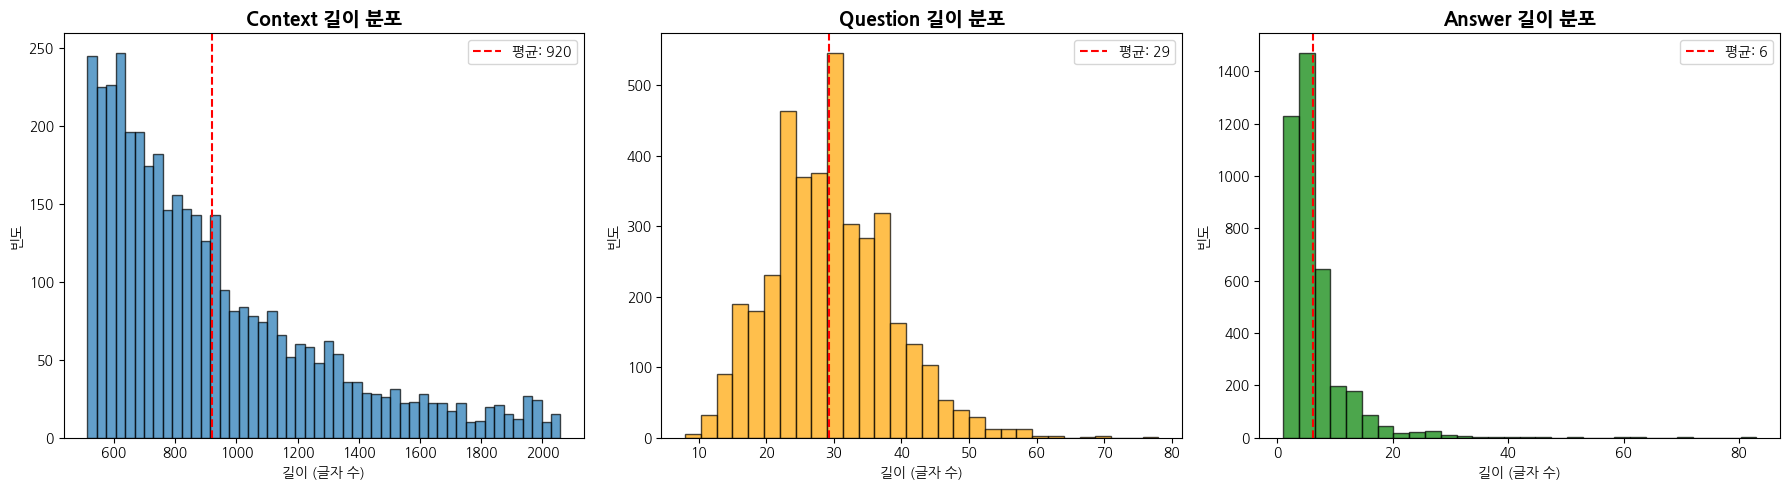


📍 답변 위치 분석

[절대 위치 통계]
평균: 376.79
중앙값: 310.00
최소: 0
최대: 1974

[상대 위치 통계 (백분율)]
평균: 41.49%
중앙값: 37.52%

[Context 구간별 답변 분포]
앞부분 (0-33%): 1826개 (46.20%)
중간부분 (33-66%): 1199개 (30.34%)
뒷부분 (66-100%): 927개 (23.46%)


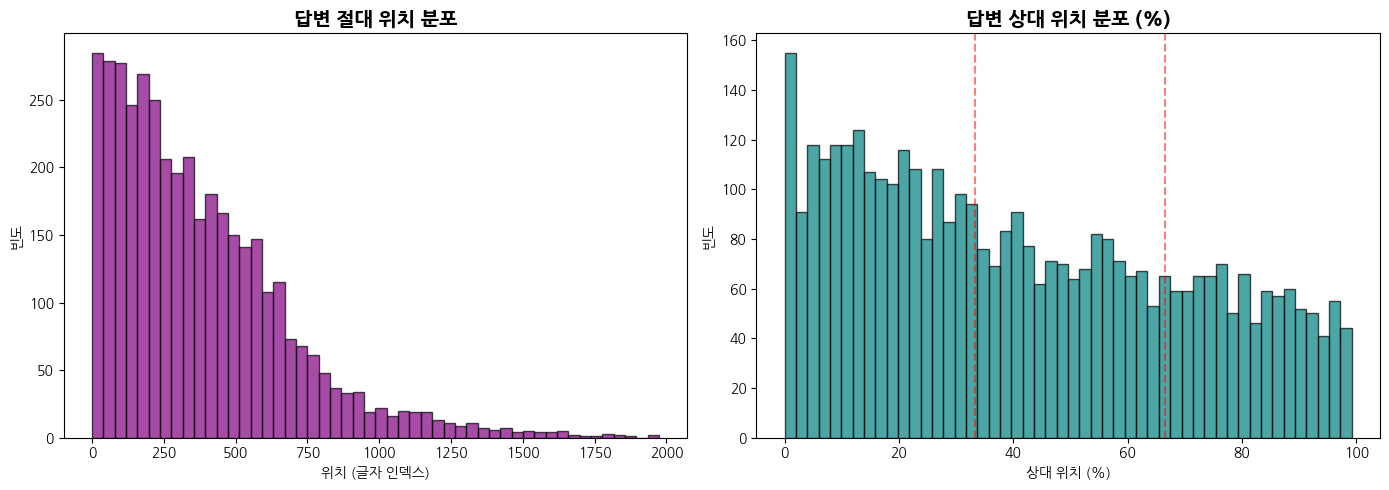


📄 Document ID 분석
고유 Document 수: 3340
평균 Document당 Question 수: 1.18
최대 Question 수를 가진 Document: 4개
최소 Question 수를 가진 Document: 1개

[상위 10개 Document]
Document 5284: 4개의 질문
Document 5322: 3개의 질문
Document 8428: 3개의 질문
Document 4633: 3개의 질문
Document 7872: 3개의 질문
Document 6216: 3개의 질문
Document 6033: 3개의 질문
Document 7870: 3개의 질문
Document 8264: 3개의 질문
Document 6998: 3개의 질문


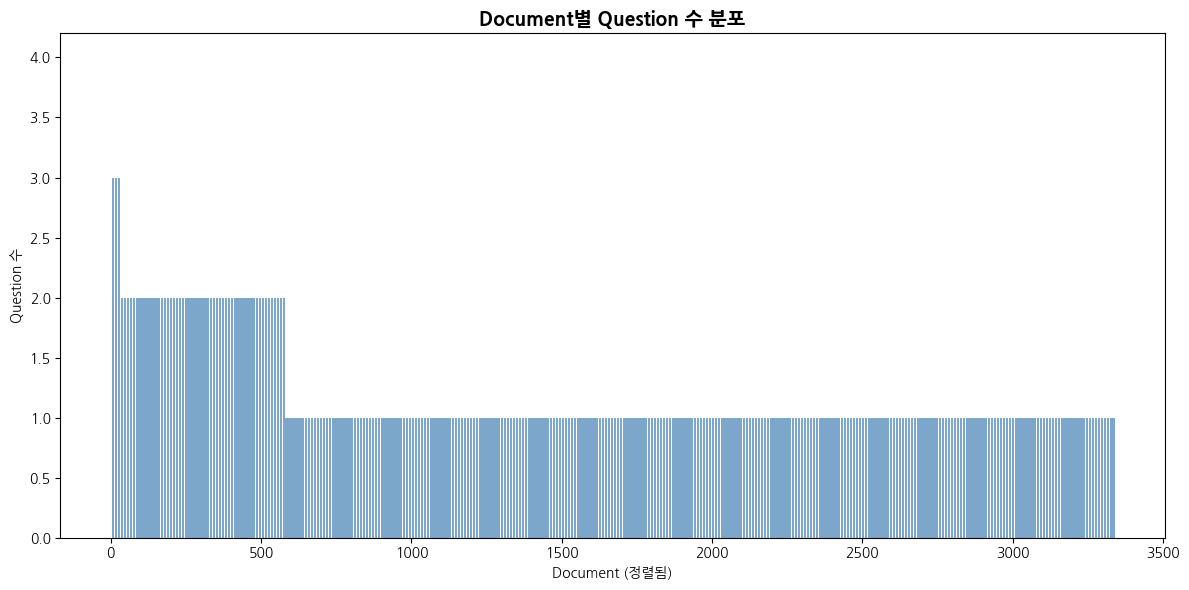


❓ 질문 유형 분석

[질문 시작 단어 TOP 20]
윤치호가: 17개 (0.43%)
교황: 9개 (0.23%)
미국: 8개 (0.20%)
윌리엄: 7개 (0.18%)
제2차: 6개 (0.15%)
요한: 6개 (0.15%)
현재: 6개 (0.15%)
기원전: 5개 (0.13%)
최초의: 5개 (0.13%)
일본이: 5개 (0.13%)
강희제가: 4개 (0.10%)
일본의: 4개 (0.10%)
2014년: 4개 (0.10%)
여운형이: 4개 (0.10%)
보니파시오: 4개 (0.10%)
이탈리아: 4개 (0.10%)
여러: 4개 (0.10%)
다수의: 4개 (0.10%)
인도: 4개 (0.10%)
사람들은: 4개 (0.10%)

[의문사 포함 빈도]
무엇: 409개 (10.35%)
누구: 305개 (7.72%)
어디: 203개 (5.14%)
언제: 135개 (3.42%)
어느: 109개 (2.76%)
몇: 99개 (2.51%)
누가: 35개 (0.89%)
무슨: 17개 (0.43%)
어떻게: 10개 (0.25%)
왜: 8개 (0.20%)


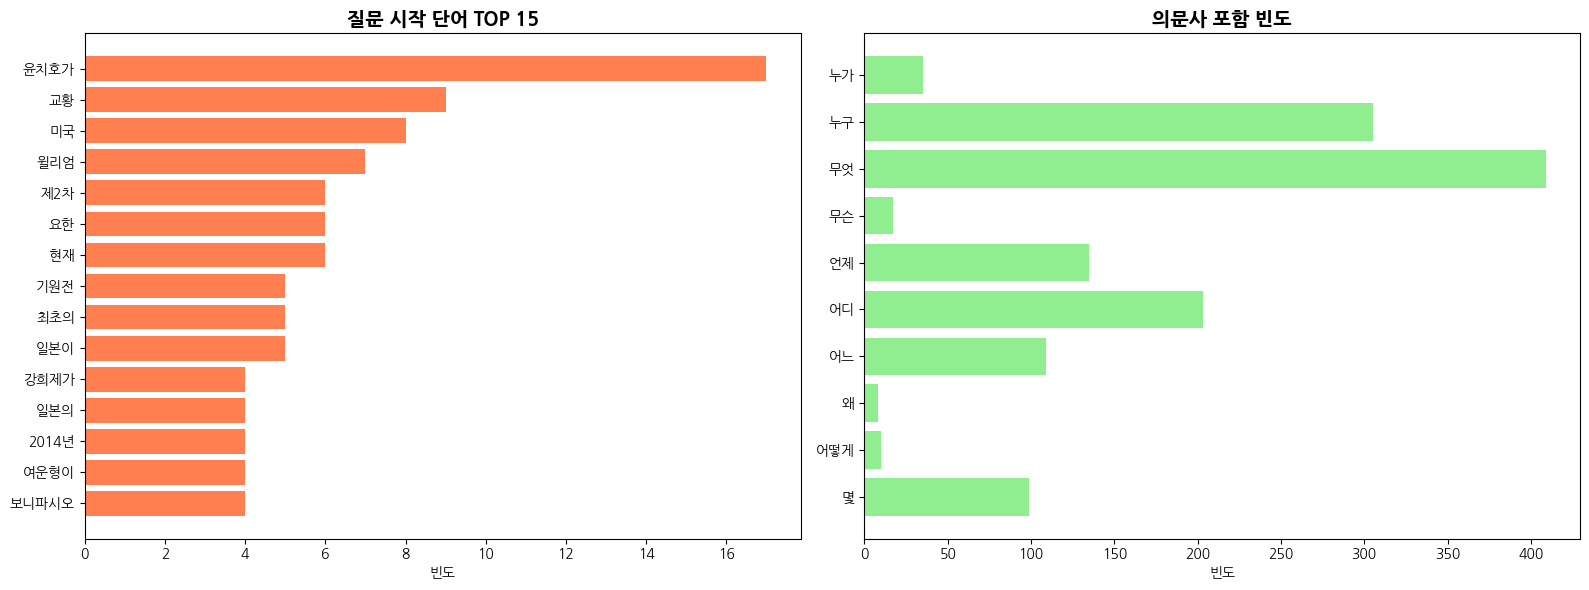

Token indices sequence length is longer than the specified maximum sequence length for this model (1020 > 512). Running this sequence through the model will result in indexing errors



📚 제목 분포 분석
고유 제목 수: 2716

[상위 20개 제목]
윤치호: 43개
장면: 24개
여운형: 23개
루트비히 비트겐슈타인: 13개
근대: 13개
데카메론의 줄거리: 13개
강희제: 11개
미치류: 11개
이오 (위성): 11개
제1차 세계 대전: 10개
박근혜 정부: 10개
자유한국당: 10개
확증 편향: 9개
고구려-당 전쟁: 9개
대한제국 고종: 9개
음식: 8개
그리스-페르시아 전쟁: 8개
튀코 브라헤: 8개
김준연: 8개
이규완: 8개

🔤 토큰 길이 분석 (BERT Tokenizer)
토큰화 진행 중...
  진행률: 0/3952
  진행률: 1000/3952
  진행률: 2000/3952
  진행률: 3000/3952

[Context 토큰 통계]
평균: 495.30 토큰
중앙값: 442.00 토큰
최소: 239 토큰
최대: 1172 토큰

[Question 토큰 통계]
평균: 16.30 토큰
중앙값: 16.00 토큰
최소: 5 토큰
최대: 43 토큰

[Combined (Q+C) 토큰 통계]
평균: 514.60 토큰
중앙값: 462.00 토큰
최소: 256 토큰
최대: 1190 토큰

[512 토큰 초과 샘플]
개수: 1545개 (39.09%)


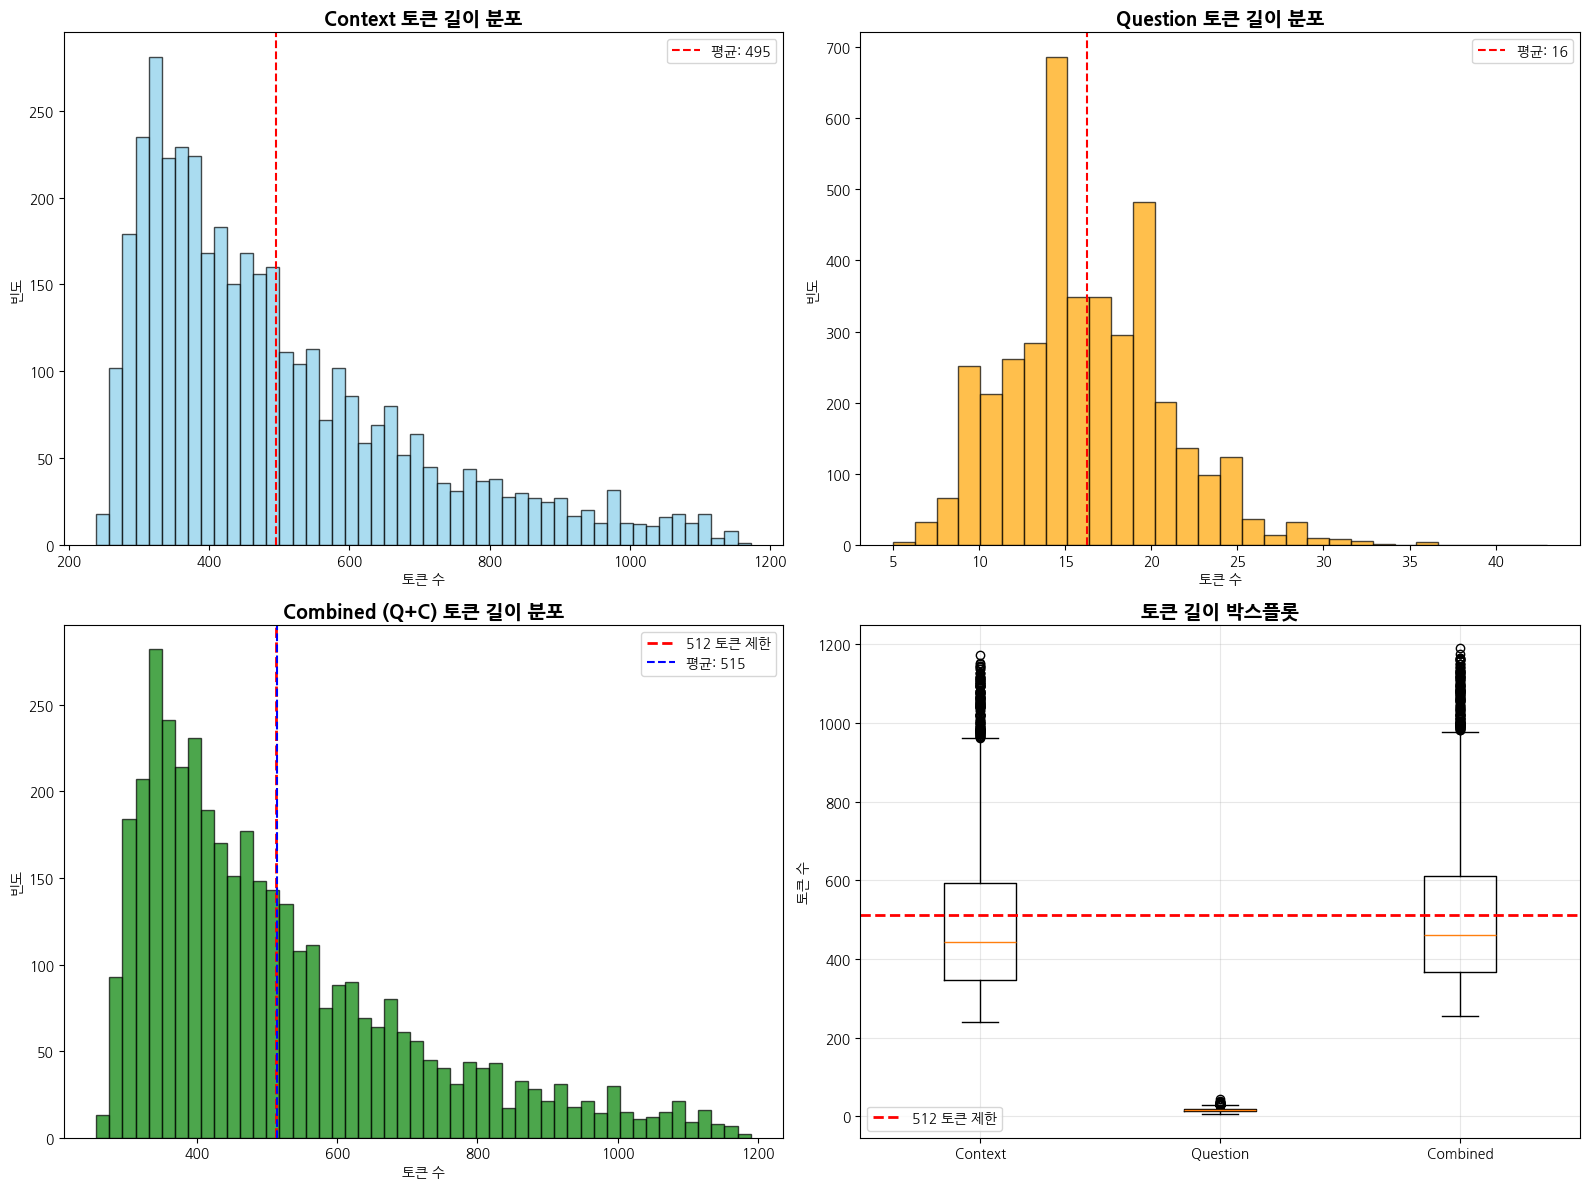


❌ 답변 불가능 질문 분석
전체 질문 수: 3952
답변 가능 질문: 3952개 (100.00%)
답변 불가능 질문: 0개 (0.00%)


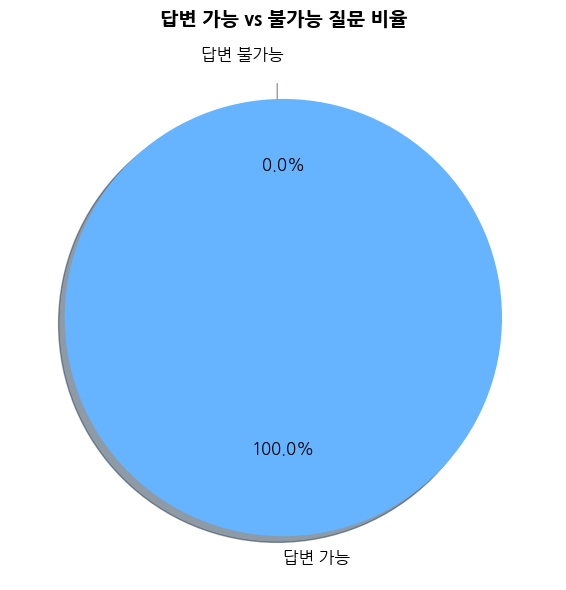


🔗 Context-Question 유사도 분석
  진행률: 0/3952
  진행률: 1000/3952
  진행률: 2000/3952
  진행률: 3000/3952

[단어 중복도 통계]
평균: 0.2805
중앙값: 0.2857
최소: 0.0000
최대: 0.8889

[문자 유사도 통계]
평균: 0.0454
중앙값: 0.0424
최소: 0.0078
최대: 0.1683


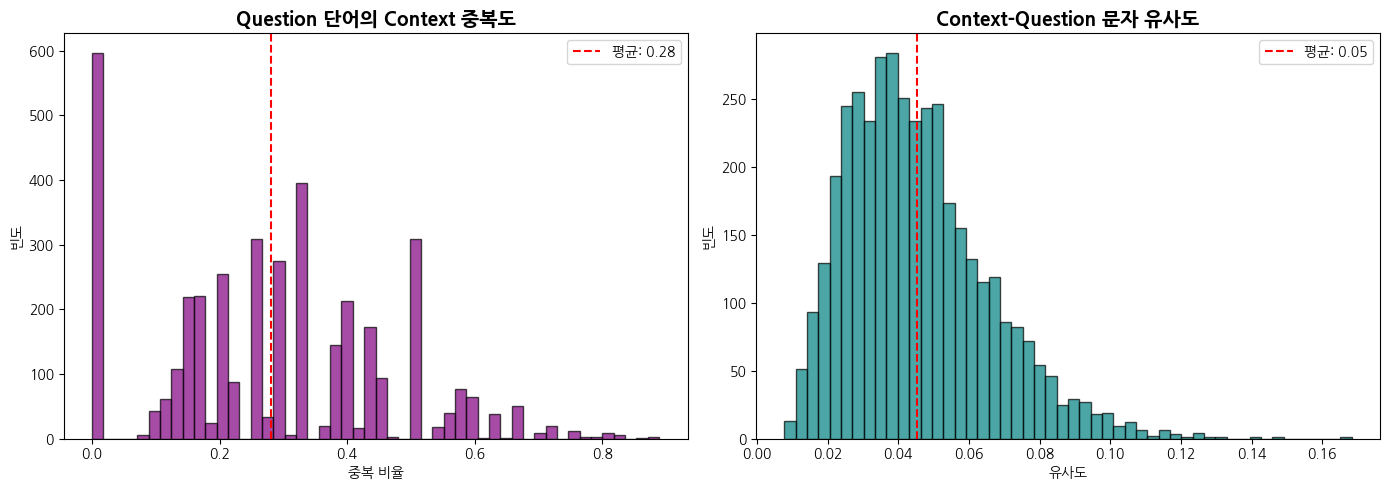


🏷️  답변 타입 분석

[답변 타입 분포]
일반 명사구: 2536개 (64.17%)
숫자: 683개 (17.28%)
지명: 492개 (12.45%)
날짜/시간: 135개 (3.42%)
인명: 73개 (1.85%)
기관/조직: 33개 (0.84%)


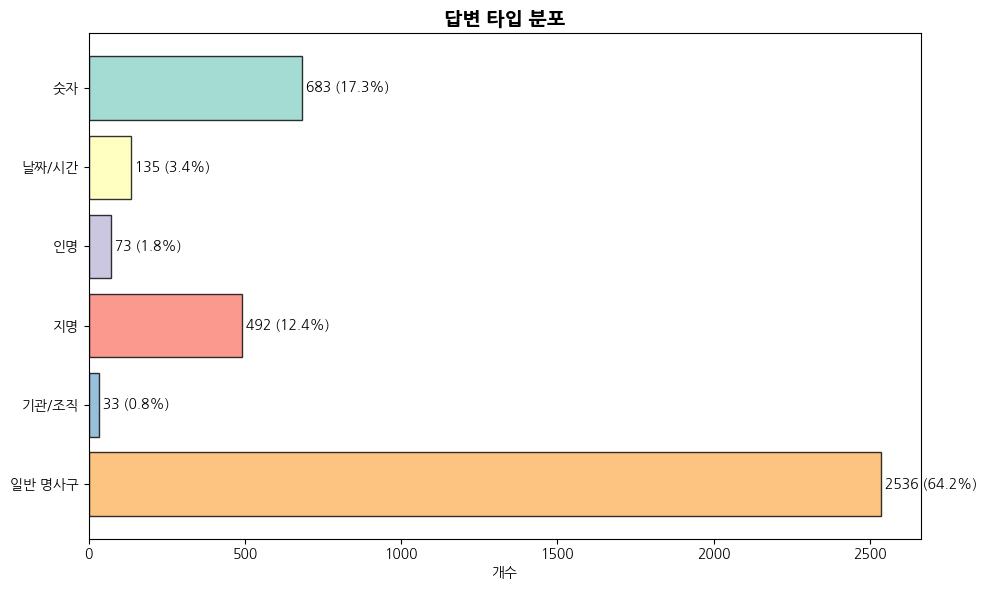


📝 문장 단위 답변 위치 분석
  진행률: 0/3952
  진행률: 1000/3952
  진행률: 2000/3952
  진행률: 3000/3952

[문장 위치 통계]
평균 답변 위치: 5.23번째 문장
중앙값: 4.00번째 문장
최소: 1번째 문장
최대: 33번째 문장

[Context 문장 수 통계]
평균: 11.03개
중앙값: 10.00개
최소: 1개
최대: 50개

처음 3개 문장 내 답변: 1646개 (41.65%)


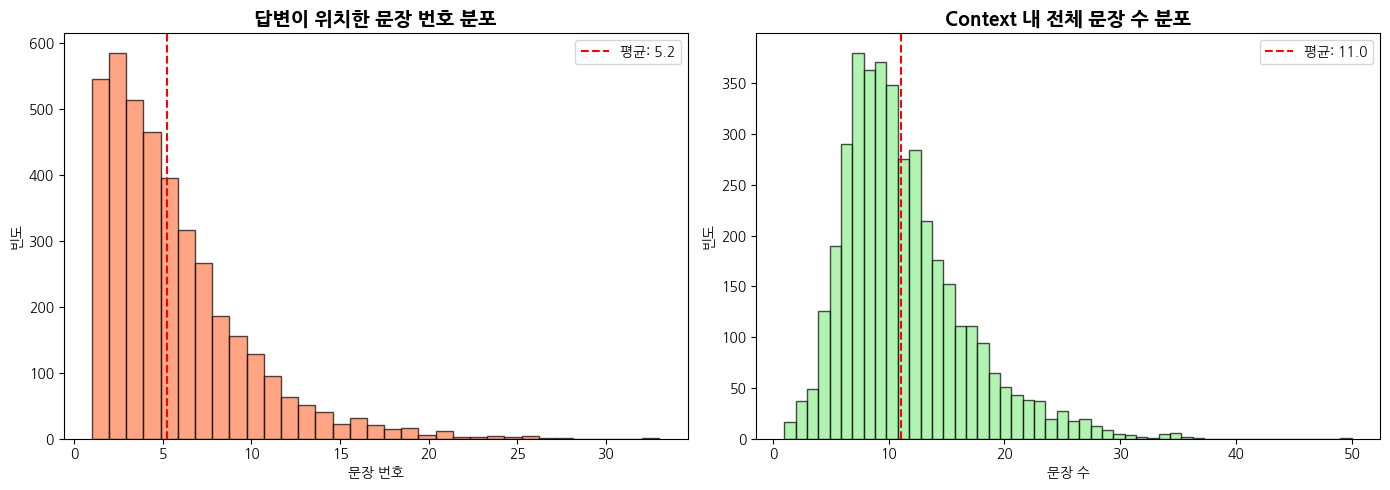


🔄 중복 및 유사 질문 분석

[중복 질문 통계]
전체 고유 질문 수: 3952
중복되는 질문 수: 0
중복 질문으로 인한 총 샘플 수: 0

[Document별 질문 다양성]
평균 고유 질문 비율: 1.0000
중앙값: 1.0000

[같은 Document 내 질문 쌍 분석]
전체 질문 쌍: 646
유사한 길이의 질문 쌍: 207 (32.04%)


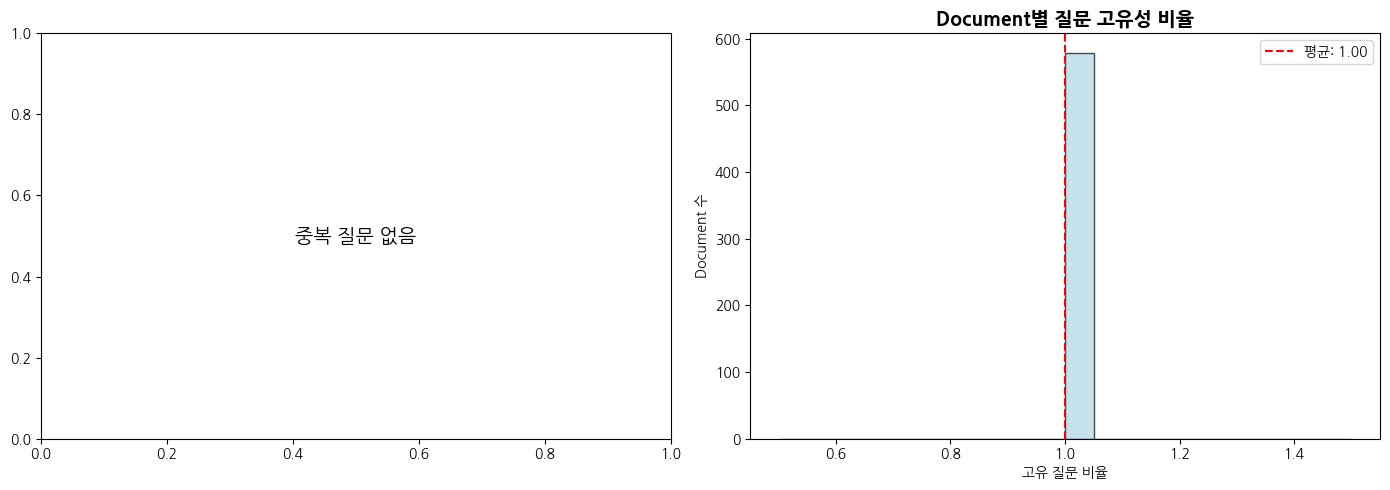


🔍 데이터 인덱스 분석 (__index_level_0__)

[기본 통계]
최소값: 0
최대값: 3593
평균값: 1496.03
중앙값: 1189.50
고유값 개수: 3120
전체 샘플 수: 3952

[데이터 연속성 분석]
예상 범위 크기: 3594
실제 샘플 수: 3952
⚠️  누락된 인덱스: 474개 (13.19%)
   → 원본 데이터에서 일부 샘플이 제거되었을 가능성
   → 누락된 인덱스 예시 (최대 10개): [34, 98, 131, 140, 145, 211, 233, 271, 289, 338]

⚠️  중복된 인덱스: 832개
   → 같은 원본 데이터가 여러 번 사용되었을 가능성
   → 중복 인덱스 개수: 832
   → 가장 많이 중복된 인덱스 TOP 5:
      Index 42: 2회
      Index 992: 2회
      Index 548: 2회
      Index 360: 2회
      Index 80: 2회

[정렬 상태]
⚠️  인덱스가 정렬되어 있지 않습니다.
   → 데이터가 셔플되었거나 재정렬되었을 가능성

[인덱스 간격 분석]
평균 간격: 0.91
최소 간격: 0
최대 간격: 6


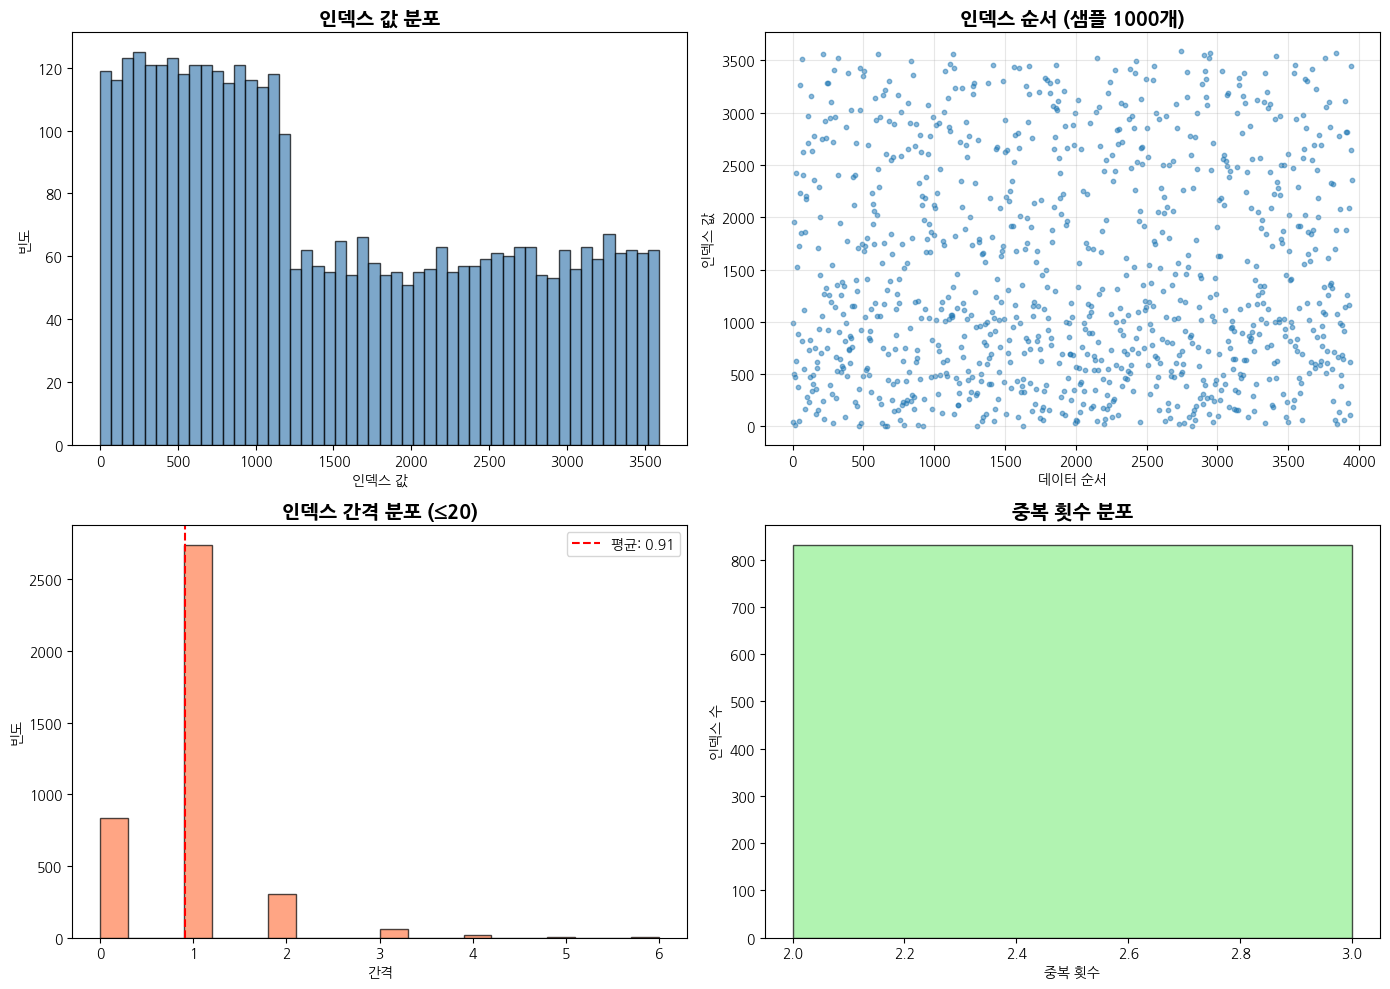


📋 데이터 품질 요약
⚠️  인덱스 연속성: 주의 (누락률 13.19%)
⚠️  인덱스 중복: 832개 존재
⚠️  인덱스 정렬: 비정렬 (셔플됨)
✅ 인덱스 간격: 균일함

종합 품질 점수: 1/4
❌ 데이터 품질에 문제가 있을 수 있습니다.

✅ 전체 EDA 완료! 생성된 그래프:
  - text_length_distribution.png
  - answer_position_distribution.png
  - document_distribution.png
  - question_type_analysis.png
  - token_length_analysis.png
  - unanswerable_questions.png
  - context_question_similarity.png
  - answer_type_distribution.png
  - sentence_level_analysis.png
  - duplicate_questions_analysis.png
  - index_level_analysis.png


In [ ]:
if __name__ == "__main__":
    # 데이터 경로 설정
    dataset_path = "/content/drive/MyDrive/data/data/train_dataset"  # HuggingFace datasets 경로

    # EDA 실행 (tokenizer는 선택 사항, 기본값: klue/bert-base)
    eda = MRCDataEDA(dataset_path, tokenizer_name='klue/bert-base')

    # 전체 분석 실행
    eda.run_full_eda()

    # 또는 개별 분석 실행
    # eda.basic_info()
    # eda.analyze_text_length()
    # eda.analyze_token_length()
    # eda.analyze_answer_position()
    # eda.analyze_document_ids()
    # eda.analyze_question_types()
    # eda.analyze_title_distribution()
    # eda.analyze_unanswerable_questions()
    # eda.analyze_context_question_similarity()
    # eda.analyze_answer_type()
    # eda.analyze_sentence_level_answer()
    # eda.analyze_duplicate_questions()
    # eda.analyze_index_level()  # 인덱스 분석